# Experiments with projective transforms

This Notebook is needed to get acquainted with projective transforms in Scikit-image.

In [1]:
# Necessary includes

# Scikit-image (for image storing)
from skimage import io
from skimage import transform
# NumPy (for fast vectorised computations)
import numpy as np
# Matplotlib (for inline image rendering)
import matplotlib.pyplot as plot

In [2]:
# Experimental placeholder IM_PATH
#
# Needs to be replaced with a varibale set by end user
# in production version of the program

IM_PATH = '../sample_images/Moscow.jpg'

## Auxiliary toolset

In [3]:
def render_image(image, grayscale=False):
    plot.figure(figsize=(10, 10))
    if grayscale:
        plot.imshow(image, cmap=plot.cm.gray)
    else:
        plot.imshow(image)
    return

## Step 1. Image load

In [4]:
image = io.imread(IM_PATH)

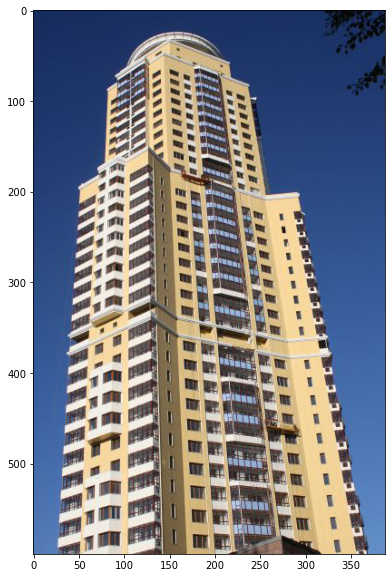

In [5]:
render_image(image)

Vanishing points detected with Hough transforms.

In [6]:
v_h, v_v = (484, 1490), (-676, 116)

## Step 2. Test rotation

In [32]:
transform_matrix = np.array([[0, -1, 0],
                             [1, 0, 0],
                             [0, 0, 5]])
translate_matrix = np.array([[1, 0, -100],
                             [0, 1, -100],
                             [0, 0, .5]])
transform_op = transform.ProjectiveTransform(translate_matrix)

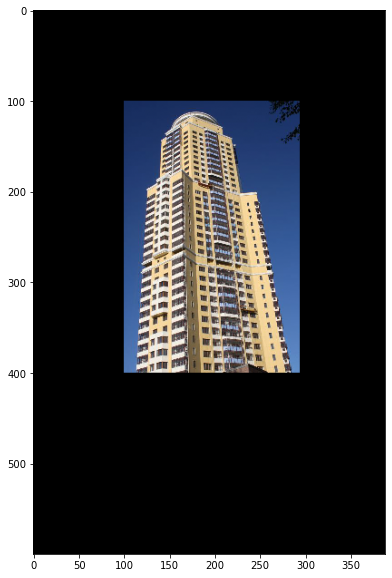

In [33]:
render_image(transform.warp(image, transform_op))